In [113]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1);
from torch.utils import data

import warnings
warnings.simplefilter("ignore", UserWarning)

## Read data

In [115]:
import sys
from dataloader import get_video_loader, train_transform, test_transform, unnormalize
import argparse

%load_ext autoreload
%autoreload 1
%aimport dataloader


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
parser = argparse.ArgumentParser(description='',
                                 formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument('--batch_size', default=16, type=int, metavar='N',
                    help='batchsize')
parser.add_argument('-j', '--workers', default=0, type=int, metavar='N',
                    help='number of data loading workers')
parser.add_argument('-c', '--checkpoint',
                    default="checkpoint_bincls_newborders", type=str,
                    metavar='PATH',
                    help='path to save checkpoint')
parser.add_argument('--frames_per_clip', type=int, default=16)
parser.add_argument('--step_between_clips', type=int, default=16)
parser.add_argument('--fps', type=int, default=8)
parser.add_argument('--local_rank', type=int, default=-1)
parser.add_argument('--clips_per_video', type=int, default=1)
parser.add_argument('--fails_path', default="train/")
parser.add_argument('--dataset_path', default="train/")

_StoreAction(option_strings=['--dataset_path'], dest='dataset_path', nargs=None, const=None, default='train/', type=None, choices=None, help=None, metavar=None)

## Model

In [117]:
import torchvision

In [118]:
mobile_net_v2 = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

class FullyConnected(torch.nn.Module):
    def __init__(self):
        super(FullyConnected, self).__init__()
        self.clas_block1 = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(1280, 100)
        )
        
    def forward(self, x):
        x = self.clas_block1(x)
        return x.view(-1, 100)

mobile_net_v2.classifier = FullyConnected()

Using cache found in /home/eromanenkova/.cache/torch/hub/pytorch_vision_v0.6.0


In [119]:
class Combine(nn.Module):
    def __init__(self):
        super(Combine, self).__init__()
        self.cnn = mobile_net_v2
        self.rnn = nn.LSTM(
            input_size=100,  # 1280 if conv block mobile net used
            hidden_size=50, 
            num_layers=1,
            batch_first=True, 
            dropout=0.5)
        self.linear_1 = nn.Linear(100,50)
        self.linear_2 = nn.Linear(50,1)
        self.linear = nn.Linear(50,1)        
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()  
        self.activation = nn.Sigmoid()        

    def forward(self, x):
        batch_size, C, timesteps, H, W = x.size()
        x = x.permute(0,2,1,3,4)
        c_in = x.reshape(batch_size * timesteps, C, H, W)
        c_in = torchvision.transforms.Resize((224, 224))(c_in)
        c_out = self.cnn(c_in)        
        
        #print(c_out.shape)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, hidden = self.rnn(r_in)
        #print(r_out.shape)
        r_out2 = self.linear(r_out.reshape(batch_size * timesteps, -1)).reshape(batch_size, timesteps, -1)
        out = self.activation(r_out2)
        return out
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(1, batch_size, 100).zero_().to(device),
                  weight.new(1, batch_size, 100).zero_().to(device))
        return hidden

In [120]:
model = Combine() 

cnt = 0
for param in model.parameters():
    cnt+=1
    if(cnt==157): break   
    param.requires_grad = False

In [121]:
device = 'cuda:0'
model = Combine()
model.to(device)

Combine(
  (cnn): MobileNetV2(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1),

In [122]:
import pytorch_lightning as pl
import torch
import torch.nn as nn

class CPD_model(pl.LightningModule):
    def __init__(
        self,
        lr: float = None,
        batch_size: int = 16,
    ):
        super(CPD_model, self).__init__()

        self.model = Combine()                
        self.lr = lr
        self.batch_size = batch_size
    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        videos, labels, _ = batch
        pred = self.forward(videos.float())

        train_loss = CustomLoss()(pred.squeeze(), labels.float().squeeze())
        train_accuracy = ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()

        self.log('train_loss', train_loss, prog_bar=True)
        self.log('train_acc', train_accuracy, prog_bar=True)    
        
        return train_loss

    def validation_step(self, batch, batch_idx):
        videos, labels, _ = batch
        pred = self.forward(videos.float())
        
        val_loss = CustomLoss()(pred.squeeze(), labels.float().squeeze())      
        val_accuracy = ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()
                
        self.log('val_loss', val_loss, prog_bar=True)    
        self.log('val_acc', val_accuracy, prog_bar=True)    
        
        return {'val_loss': val_loss, 'val_acc': val_accuracy}
    

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=0.0001) 
        stp = torch.optim.lr_scheduler.StepLR(opt, 5, gamma=0.9)

        return [opt], [stp]

    def train_dataloader(self):
        
        train_args = ['--batch_size', str(self.batch_size), '--workers', '3', '--checkpoint', 'checkpoint_bincls_newborders', 
                      '--frames_per_clip', '16', '--step_between_clips', '16', '--fps', '8',
                      '--local_rank', '-1', '--clips_per_video', '1', '--fails_path', 'train/']
        train_args = parser.parse_args(train_args)
        return get_video_loader(**vars(train_args), val=False, transform=train_transform)
    
    def val_dataloader(self):
        
        test_args = ['--batch_size', str(self.batch_size), '--workers', '3', '--checkpoint', 'checkpoint_bincls_newborders', 
                     '--frames_per_clip', '16', '--step_between_clips', '16', '--fps', '8',
                     '--local_rank', '-1', '--clips_per_video', '1', '--fails_path', 'val/']
        test_args = parser.parse_args(test_args)
        return get_video_loader(**vars(test_args), val=True, transform=test_transform)    

In [125]:
test_args = ['--batch_size', '16', '--workers', '4', '--checkpoint', 'checkpoint_bincls_newborders', 
             '--frames_per_clip', '16', '--step_between_clips', '16', '--fps', '8',
             '--local_rank', '-1', '--clips_per_video', '1', '--fails_path', 'val/']
test_args = parser.parse_args(test_args)
test_loader = get_video_loader(**vars(test_args), val=True, transform=test_transform)    

  0%|          | 5/1233 [00:00<00:25, 47.36it/s]

Loaded dataset from train/val_videoclips.pth


100%|██████████| 1233/1233 [00:11<00:00, 107.06it/s]

Good clips: 2371
Only ones: 1629
Without labels: 309


In [245]:
test_loader_iter = iter(test_loader)
for batch_idx, (batch, labels, _) in enumerate(test_loader_iter):
    if batch_idx == 1:
        break

In [246]:
labels

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [240]:
batch = batch.to(device)

In [231]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [232]:
model_custom = CPD_model()
model_custom.load_state_dict(torch.load('custom_loss_oops_300_epoch.pth'))
model_custom.to(device)

CPD_model(
  (model): Combine(
    (cnn): MobileNetV2(
      (features): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
  

In [207]:
model_bce = CPD_model()
model_bce.load_state_dict(torch.load('bce_loss_100_epochs.pth'))
model_bce.to(device)

CPD_model(
  (model): Combine(
    (cnn): MobileNetV2(
      (features): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
  

In [208]:
predictions = model_custom(batch)
predictions_bce = model_bce(batch)

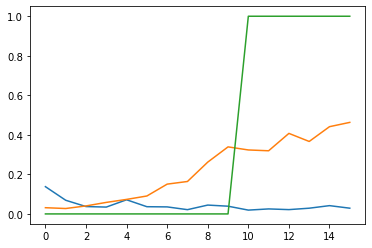

In [236]:
i = 0
plt.plot(predictions[i].detach().cpu())
plt.plot(predictions_bce[i].detach().cpu())
plt.plot(labels)

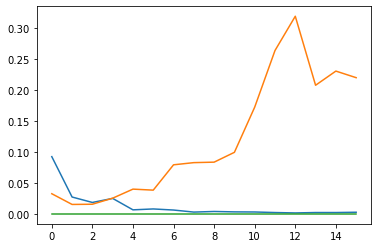

In [210]:
i = 2
plt.plot(predictions[i].detach().cpu())
plt.plot(predictions_bce[i].detach().cpu())
plt.plot(labels[i].detach().cpu())

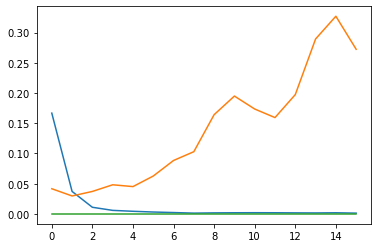

In [211]:
i = 3
plt.plot(predictions[i].detach().cpu())
plt.plot(predictions_bce[i].detach().cpu())
plt.plot(labels[i].detach().cpu())

In [152]:
predictions = model_bce(batch)

CPD_model(
  (model): Combine(
    (cnn): MobileNetV2(
      (features): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
  

In [14]:
def evaluate_metrics(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false negatives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_truei
    """
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    seq_len = 16 
    
    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = real_change_index.item()
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()
    
    return false_positive, false_negative, delay, false_positive_delay, accuracy

In [15]:
def get_quality_metrics(test_loader, model, threshold=0.5, LSTM_flag=False):
    test_loss_list = []
    test_acc_list = []

    positive_number = 0 
    negative_number = 0
    fp_list = []
    fn_list = []
    delay_list = []
    fp_delay_list = []
    accuracy_list = []

    test_batch_size = 16
    
    model.eval()
    for test_inputs, test_true_labels, _ in tqdm(test_loader):

        if test_inputs.shape[0] < test_batch_size:
            break
            
        test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)

        test_predictions = model(test_inputs)
            
        for i in range(0, test_batch_size):
            curr_labels = test_true_labels[i]
            curr_predictions = test_predictions[i]
            
            # torch.rand_like
            curr_fp, curr_fn, curr_delay, curr_fp_delay, curr_accuracy = evaluate_metrics(curr_labels, curr_predictions, 
                                                                           threshold)

            max_difference = np.abs((curr_labels.max() - curr_labels.min()).item())
            if max_difference: 
                delay_list.append(curr_delay)
            positive_number += (max_difference > 0)
            negative_number += 1 - (max_difference > 0)

            fp_list.append(curr_fp)
            fn_list.append(curr_fn)
            fp_delay_list.append(curr_fp_delay)
            accuracy_list.append(curr_accuracy)

        test_acc_list.append(np.mean(accuracy_list[-test_batch_size:]))
        
    return (positive_number, negative_number, np.mean(test_loss_list), np.mean(test_acc_list), np.mean(delay_list),
            np.mean(fp_delay_list), np.sum(fp_list), np.sum(fn_list))

In [16]:
def get_pareto_metrics_for_threshold(model, test_loader, threshold_list):
    fp_number_list = []
    fn_number_list = []
    delay_list = []
    fp_delay_list = []
    for threshold in threshold_list:
        # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)
        (positive_number, negative_number, test_loss, 
         test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold)

        fp_number_list.append(fp_number)
        fn_number_list.append(fn_number)
        delay_list.append(mean_delay)
        fp_delay_list.append(mean_fp_delay)
        print(threshold, fp_number, fn_number, mean_delay, mean_fp_delay)
    
    return fp_number_list, fn_number_list, delay_list, fp_delay_list

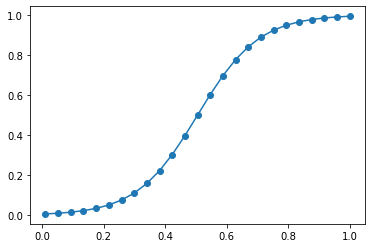

In [17]:
threshold_number = 25
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
plt.plot(np.linspace(0.01, 1, threshold_number), threshold_list, '-o')

In [18]:
threshold_list

array([0.00669285, 0.01011736, 0.01526715, 0.02297737, 0.0344452 ,
       0.05133579, 0.07585818, 0.11072732, 0.1588691 , 0.22270014,
       0.30294072, 0.39731466, 0.5       , 0.60268534, 0.69705928,
       0.77729986, 0.8411309 , 0.88927268, 0.92414182, 0.94866421,
       0.9655548 , 0.97702263, 0.98473285, 0.98988264, 0.99330715])

CPD_model(
  (model): Combine(
    (cnn): MobileNetV2(
      (features): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
  

In [20]:
(fp_number_list_2, fn_number_list_2, 
 delay_list_2, fp_delay_list_2) = get_pareto_metrics_for_threshold(model_custom, test_loader, threshold_list)


0.0066928509242848554 888 0 0.32167832167832167 7.051535087719298


/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



0.010117362974975634 887 0 0.35664335664335667 7.121710526315789



0.015267153880374444 887 0 0.3706293706293706 7.191885964912281



0.022977369910025615 887 0 0.3776223776223776 7.235745614035087



0.03444519566621118 887 0 0.3776223776223776 7.303728070175438



0.05133579311531625 887 0 0.38461538461538464 7.357456140350878



0.07585818002124355 887 0 0.3916083916083916 7.407894736842105



0.11072731797236826 887 0 0.40559440559440557 7.451754385964913



0.15886910488091516 887 0 0.4125874125874126 7.495614035087719



0.22270013882530884 887 0 0.42657342657342656 7.529605263157895



0.30294071603459277 887 0 0.42657342657342656 7.576754385964913



0.3973146620215085 887 0 0.43356643356643354 7.620614035087719



0.5 887 0 0.44755244755244755 7.671052631578948



0.6026853379784918 887 0 0.45454545454545453 7.708333333333333



0.6970592839654074 887 0 0.46153846153846156 7.755482456140351



0.7772998611746911 887 0 0.46853146853146854 7.800438596491228



0.8411308951190849 887 0 0.4755244755244755 7.850877192982456



0.8892726820276319 887 0 0.4825174825174825 7.904605263157895



0.9241418199787566 887 0 0.4965034965034965 8.014254385964913



0.9486642068846839 885 0 0.5034965034965035 8.198464912280702



0.9655548043337889 878 0 0.5524475524475524 8.508771929824562



0.9770226300899744 870 0 0.6223776223776224 9.112938596491228



0.9847328461196255 849 0 0.8111888111888111 9.666666666666666



0.9898826370250243 816 0 1.0769230769230769 10.453947368421053



0.9933071490757153 764 0 1.3846153846153846 11.380482456140351


In [69]:
count = 0
total = 0
for batch, labels, _ in test_loader:
    count += (labels.sum(1) != 0).sum()
    total += labels.shape[0]

In [70]:
count

tensor(144)

In [71]:
len(test_loader)
total

924

In [109]:
train_args = ['--batch_size', str(16), '--workers', '3', '--checkpoint', 'checkpoint_bincls_newborders', 
              '--frames_per_clip', '16', '--step_between_clips', '16', '--fps', '8',
              '--local_rank', '-1', '--clips_per_video', '1', '--fails_path', 'train/']
train_args = parser.parse_args(train_args)
train_loader = get_video_loader(**vars(train_args), val=False, transform=train_transform)


  2%|▏         | 17/1000 [00:00<00:06, 162.83it/s]

Loaded dataset from train/train_videoclips.pth


100%|██████████| 1000/1000 [00:06<00:00, 162.08it/s]

Good clips: 1840
Only ones: 1246
Without labels: 261
Dataset contains 1840 items


In [110]:
count = 0
total = 0
for batch, labels, _ in tqdm(train_loader):
    count += (labels.sum(1) != 0).sum()
    total += labels.shape[0]

print(count.item())
print(total)


519
1327


In [100]:
print(total)

739


In [111]:
x = torch.load('train_videoclips.pth')

In [112]:
torch.save(x.subset(range(1500)), 'train/train_videoclips.pth')

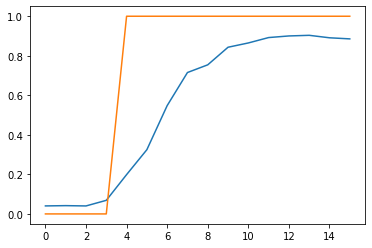

In [87]:
plt.plot(model_bce(batch.to(device)).detach().cpu()[-4])
plt.plot(labels[-1])

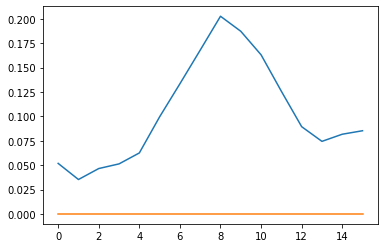

In [44]:
plt.plot(model_bce(batch.to(device)).detach().cpu()[4])
plt.plot(labels[4])

In [45]:
labels

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

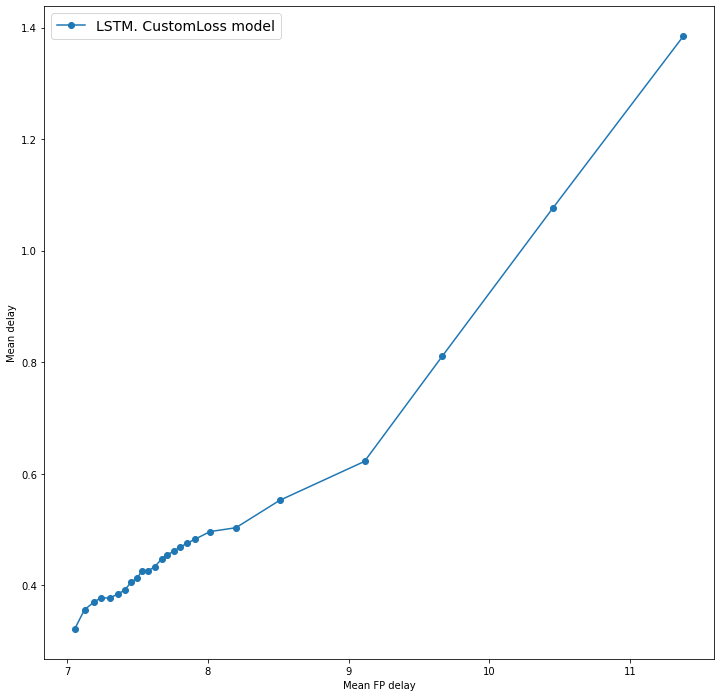

In [22]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_2, delay_list_2, '-o', label='LSTM. CustomLoss model')
plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);

In [23]:
model_bce = CPD_model()
model_bce.load_state_dict(torch.load('bce_loss_100_epochs.pth'))

<All keys matched successfully>

In [24]:
model_bce.to(device)

CPD_model(
  (model): Combine(
    (cnn): MobileNetV2(
      (features): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
  

In [25]:
(fp_number_list_bce_2, fn_number_list_bce_2, 
 delay_list_bce_2, fp_delay_list_bce_2) = get_pareto_metrics_for_threshold(model_bce, test_loader, threshold_list)


0.0066928509242848554 912 0 0.0 0.0



0.010117362974975634 912 0 0.0 0.0



0.015267153880374444 912 0 0.0 0.0



0.022977369910025615 910 0 0.0 0.18311403508771928



0.03444519566621118 894 0 0.006993006993006993 2.0975877192982457



0.05133579311531625 869 0 0.04195804195804196 4.6173245614035086



0.07585818002124355 790 4 0.1258741258741259 7.141447368421052



0.11072731797236826 693 7 0.24475524475524477 9.264254385964913



0.15886910488091516 563 13 0.4825174825174825 11.146929824561404



0.22270013882530884 412 22 0.7832167832167832 12.655701754385966



0.30294071603459277 277 28 1.2797202797202798 13.663377192982455



0.3973146620215085 186 44 1.993006993006993 14.387061403508772



0.5 114 52 2.4685314685314683 14.791666666666666



0.6026853379784918 64 61 3.0839160839160837 15.06359649122807



0.6970592839654074 35 80 3.7482517482517483 15.31469298245614



0.7772998611746911 18 92 4.363636363636363 15.451754385964913



0.8411308951190849 9 108 4.937062937062937 15.637061403508772



0.8892726820276319 2 123 5.4475524475524475 15.8125



0.9241418199787566 0 141 5.881118881118881 15.976973684210526



0.9486642068846839 0 143 5.93006993006993 16.0



0.9655548043337889 0 143 5.93006993006993 16.0



0.9770226300899744 0 143 5.93006993006993 16.0



0.9847328461196255 0 143 5.93006993006993 16.0



0.9898826370250243 0 143 5.93006993006993 16.0



0.9933071490757153 0 143 5.93006993006993 16.0


In [28]:
fp_delay_list_2 = [0] + fp_delay_list_2 
delay_list_2 = [0] + delay_list_2

In [30]:
fp_delay_list_2 = fp_delay_list_2 + [16] 
delay_list_2 = delay_list_2 + [6]

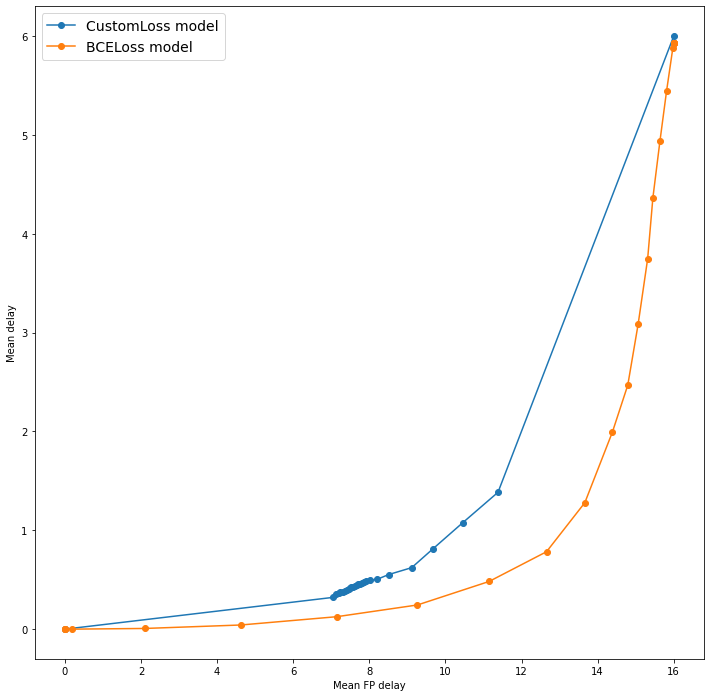

In [31]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_2, delay_list_2, '-o', label='CustomLoss model')
plt.plot(fp_delay_list_bce_2, delay_list_bce_2, '-o', label='BCELoss model')
plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);

In [ ]:
test_transform

In [69]:
model_bce = CPD_model()
model_bce.load_state_dict(torch.load('bce_loss_100_epochs.pth'))

<All keys matched successfully>

In [70]:
model_bce.to(device)

CPD_model(
  (model): Combine(
    (cnn): MobileNetV2(
      (features): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
  

In [71]:
result_bce = metrics.evaluate_metrics_on_set(model_bce, test_loader, 16, device)

TP: 381 TN: 1377 FP: 266 FN: 344 DELAY: 0.4683277027027027 FP_DELAY 8.062922297297296
